<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q3_folder/Q3_Activation_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How do activation functions affect a neural networks performance?

This notebook builds upon the previous Q2 notebook to explore how one of our neural network parameters affects its performance. From previous testing we see that our neural network didn't perform well when trying to predict psychological scores in the dataset.

We will continue this testing by using various activation functions to see how it affects the networks performance.

**Dataset:** Online Gaming Anxiety Data from Kaggle
**Target Variables:** GAD_T, SWL_T, SPIN_T

# What are activation functions?

An activation function takes the data from our dataset and creates a line which has a specific gradient for the corresponding value for each data point. This gradient tells our network how to learn:

- Steep gradients, tells our neural network to learn better from this data
- Shallow gradients, tells our neural network to learn less effectively from this data.

# Visualising the functions

Its much easier to see how each function treats the data than truing to imagine it, so lets create some plots to see the lines

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from functions import plot_activation_functions

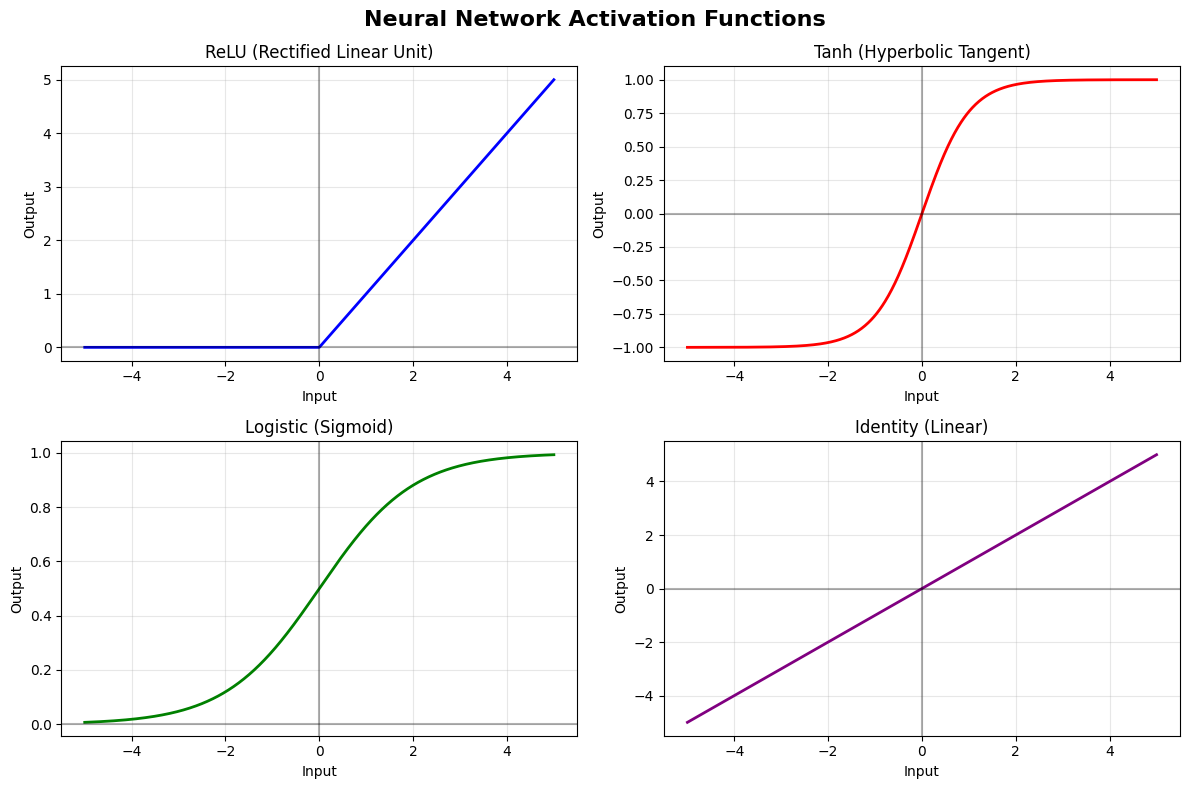

In [4]:
plot_activation_functions()

# What we can tell from the plots

Relu:
- Doesn't learn at all from negative values, Gradient = 0
- Learns well from positve values, Gradient = 1

Tanh:
- Learns well from smaller values, steeper gradient near 0
- Learns less effectively with extreme values, shallower gradient away from 0

Logistic/Sigmoid:
- Works the same as tanh but all gradients are dampened
- Maximum gradient = 0.5 at x = 0

Linear:
- Gives all inputs a gradient of 1


# Testing

How will we approach our question?

We will use our initial code from Q2 to clean our data and setup our neural network. We will then use each activation function and measure its R2 value and the time taken to train our neural network.

Note* - due to our previous results we will do this experiment twice, one with early stopping and one without as we have seen that our network struggles to learn from this complex data as psychology is hard to predict. We will see if all activations stop after a similar amount of iterations and how this affects accuracy, and then see how the lack of early stopping affects the training time. This second experiment will have a fewer number of iterations to help speed up our experiment due to Colab's slower processing speed.

Let's begin by importing the rest of our libraries


In [9]:
# Import necessary libraries
import sys # Used for system-specific parameters and functions, such as modifying the Python path.
import os  # Provides a way of using operating system dependent functionality, such as file paths.

# Add parent directory to path to import our functions
# This line ensures Python can find our custom 'functions.py' file, which contains
# helper functions for data cleaning, encoding, splitting, and scaling.
sys.path.append('..')

# Core data manipulation and visualisation libraries
# pandas is crucial for handling data in tables (DataFrames).
import pandas as pd
# numpy is used for numerical operations, especially with arrays.
import numpy as np
# matplotlib is a foundational library for creating visualisations.
import matplotlib.pyplot as plt
# seaborn is built on matplotlib and provides a higher-level graphics.
import seaborn as sns
import time

# Machine learning and preprocessing libraries from scikit-learn
# train_test_split: for dividing data into training and testing sets.
# cross_val_score: for evaluating model performance using cross-validation.
# GridSearchCV: for hyperparameter tuning (finding the best parameters for a model).
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# StandardScaler: for standardising features by removing the mean and scaling to unit variance.
# LabelEncoder: for converting categorical labels into numerical format.
# MinMaxScaler: for scaling features to a given range, usually between zero and one.
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# mean_squared_error, mean_absolute_error, r2_score: metrics to evaluate regression model performance.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# MLPRegressor: Multi-layer Perceptron regressor, a type of neural network for regression tasks.
from sklearn.neural_network import MLPRegressor
# MultiOutputRegressor: a strategy for fitting a single regressor on multiple targets.
from sklearn.multioutput import MultiOutputRegressor

# System and warnings
# This line is used to ignore warning messages that might clutter the output.
import warnings
warnings.filterwarnings('ignore')

Importing our functions

In [10]:
# From our 'functions.py' file, we import specific helper functions.
# These functions encapsulate common data processing steps, making our main notebook cleaner and more organised.
# - clean_data: handles initial data cleaning (e.g., duplicates, basic missing value handling).
# - encode_features: converts non-numerical (categorical) data into numerical format that machine learning models can understand.
# - split_data: divides the dataset into training and testing sets.
# - scale_features: normalises or standardises numerical features.
from functions import clean_data, encode_features, split_data, scale_features
from functions import plot_r2_values, plot_mae_values

Reading and storing the data

In [11]:
# Load the dataset from a CSV file into a pandas DataFrame.
# The 'encoding' parameter is specified to handle potential character encoding issues in the file.
# We use a try-except block to gracefully handle the case where the file might not be found.
try:
  df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

except FileNotFoundError:
  print(" File not found! Please upload your dataset first.")

Select our feature and target columns

In [12]:
# Define the columns that will be used as input features for our Neural Network.
# These are the independent variables (X) that the network will use to make predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Define the target columns. These are the dependent variables (y) we want to predict.
# Our network will try to learn the relationship between 'feature_columns' and 'target_columns'.
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# Create a new DataFrame 'df' containing only the selected feature and target columns.
df = df[feature_columns + target_columns].copy()

Initial data cleaning

In [13]:
# Calls the 'clean_data' function (imported from functions.py) to handle initial data cleaning steps.
# This function removes duplicate rows and displays information about missing values.
# The cleaned data is stored in a new DataFrame called 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)

Cleaning dataset...
Missing values per column:
GADE          649
Game            0
Hours          30
earnings        0
whyplay         0
streams       100
Narcissism     23
Gender          0
Age             0
Work           38
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64
Removed 0 rows with missing values
Removed 51 duplicate rows


Encoding our values and second clean

In [14]:
# We will encode the string values (categorical features) into corresponding numbers using 'encode_features'.
# This is necessary because Neural Networks typically require numerical inputs.
df_encoded = encode_features(df_cleaned_initial)

# We will then clean up any remaining missing values by dropping rows that contain NaN (Not a Number).
# This ensures that our final dataset 'df_clean' is entirely numerical and free of missing data.
df_clean = df_encoded.dropna()

# Print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
# If there are still missing values, this block will print which columns contain them.
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


 Original Missing values: 1490
 Missing values after cleaning and encoding: 0


Now we will encode our data using Standard scaling, this may cause some bias that we will explore later.

In [15]:
# Separate the features (X) from the target variables (y).
# X contains the input data, and y contains the values we want to predict.
X = df_clean[feature_columns]
y = df_clean[target_columns]

# Define the proportion of data to be used for testing (20%) and a random state for reproducibility.
test_size = 0.2
random_state = 42

# Split the data into training and testing sets using the split_data function.
# X_train, y_train are used to train the model.
# X_test, y_test are used to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

# Initialise StandardScaler to normalise the feature data.
# Scaling is important for neural networks as it helps with faster convergence and better performance.
scaler = StandardScaler()
# Fit the scaler on the training features and then transform both training and test features.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialise another StandardScaler for the target variables.
# It's good practice to scale target variables as well when using regression models.
target_scaler = StandardScaler()
# Fit and transform the training target variables.
y_train_scaled = target_scaler.fit_transform(y_train)
# Transform the test target variables (using the scaler fitted on training targets).
y_test_scaled = target_scaler.transform(y_test)

Now is the time we will set up our neural network structure, we will create and train each neural network inside a for loop to train all models in one piece of code for convenience.

In [30]:
# Define activation functions to test
activation_funcs = ['relu', 'tanh', 'logistic', 'identity']
results = []

# Store loss curves for visualisation
loss_curves = {}

for activation in activation_funcs:
    print(f"\n Testing {activation.upper()} activation...")

    # Create model with current activation function
    model = MLPRegressor(
    #Defines the architecture of the hidden layers. (128, 64, 32, 16) means 4
    # hidden layers with (128, 64, 32, 16) neurons respectively.
    hidden_layer_sizes=(128, 64, 32, 16),
    #The activation function for the hidden layers. 'tanh' is a common choice, especially for multi-layer perceptrons.
    activation = activation,
    #The algorithm for weight optimisation. 'adam' is an efficient stochastic optimiser.
    solver='adam',
    #The size of minibatches for stochastic optimisers. 16 is a common batch size, affecting how often the model's weights are updated.
    batch_size=16,
    # alpha: L2 regularisation term parameter. Helps prevent overfitting by penalising large weights.
    alpha=0.001,
    # learning_rate: How the learning rate is adjusted over time. 'adaptive' decreases it when validation score stops improving.
    learning_rate='adaptive',
    # learning_rate_init: The initial learning rate. Controls the step size at each iteration while moving towards a minimum of the loss function.
    learning_rate_init=0.01,
    # max_iter: The maximum number of epochs (iterations over the entire training data).
    max_iter=100,
    # random_state: Ensures reproducibility of the results by fixing the random number generator.
    random_state=42,
    # verbose: If True, prints progress messages to stdout during training.
    verbose=False,
    # early_stopping: Whether to use early stopping to terminate training when validation score is not improving.
    early_stopping=True,
    # validation_fraction: The proportion of training data to set aside as validation set for early stopping.
    validation_fraction=0.1,
    # n_iter_no_change: Maximum number of epochs to not meet `tol` improvement before early stopping.
    n_iter_no_change=20
)

    # Measure training time
    start_time = time.time()

    # Train model and capture loss curve
    class LossHistory:
        def __init__(self):
            self.losses = []
            self.training_time = None

    history = LossHistory()

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Record training time
    training_time = time.time() - start_time
    history.training_time = training_time

    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)

    # Inverse transform the scaled predictions back to their original scale.
    # This makes the predictions interpretable in the original units of GAD_T, SWL_T, and SPIN_T.
    y_pred = target_scaler.inverse_transform(y_pred_scaled)

    # Calculate metrics for each target
    metrics = {'activation': activation, 'training_time': training_time}

    for i, target in enumerate(target_columns):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])

        metrics[f'{target}_MSE'] = mse
        metrics[f'{target}_MAE'] = mae
        metrics[f'{target}_R2'] = r2

    # Get loss curve from the trained model
    # MLPRegressor stores a loss_curve_ attribute after training
    if hasattr(model, 'loss_curve_'):
        loss_curves[activation] = model.loss_curve_

    results.append(metrics)

    print(f"  Training time: {training_time:.2f} seconds")
    for target in target_columns:
        print(f"  {target}: MSE={metrics[f'{target}_MSE']:.3f}, MAE={metrics[f'{target}_MAE']:.3f}, R2={metrics[f'{target}_R2']:.3f}")


 Testing RELU activation...
  Training time: 21.68 seconds
  GAD_T: MSE=12.706, MAE=2.712, R2=0.407
  SWL_T: MSE=42.110, MAE=5.385, R2=0.163
  SPIN_T: MSE=150.962, MAE=9.650, R2=0.137

 Testing TANH activation...
  Training time: 14.56 seconds
  GAD_T: MSE=13.081, MAE=2.789, R2=0.389
  SWL_T: MSE=42.142, MAE=5.383, R2=0.162
  SPIN_T: MSE=153.310, MAE=9.860, R2=0.124

 Testing LOGISTIC activation...
  Training time: 34.90 seconds
  GAD_T: MSE=13.059, MAE=2.707, R2=0.390
  SWL_T: MSE=41.684, MAE=5.344, R2=0.172
  SPIN_T: MSE=151.452, MAE=9.589, R2=0.135

 Testing IDENTITY activation...
  Training time: 6.59 seconds
  GAD_T: MSE=18.019, MAE=3.093, R2=0.159
  SWL_T: MSE=45.886, MAE=5.646, R2=0.088
  SPIN_T: MSE=170.018, MAE=10.038, R2=0.028


Let's convert our results to a pandas DataFrame for easier manipulation

In [31]:
results_df = pd.DataFrame(results)
print("EXPERIMENT RESULTS")
print(results_df.round(4).to_string(index=False))

EXPERIMENT RESULTS
activation  training_time  GAD_T_MSE  GAD_T_MAE  GAD_T_R2  SWL_T_MSE  SWL_T_MAE  SWL_T_R2  SPIN_T_MSE  SPIN_T_MAE  SPIN_T_R2
      relu        21.6752    12.7065     2.7121    0.4068    42.1095     5.3855    0.1631    150.9622      9.6499     0.1373
      tanh        14.5643    13.0813     2.7886    0.3893    42.1423     5.3827    0.1624    153.3098      9.8596     0.1239
  logistic        34.8984    13.0587     2.7066    0.3904    41.6842     5.3443    0.1715    151.4525      9.5888     0.1345
  identity         6.5941    18.0195     3.0927    0.1588    45.8855     5.6464    0.0880    170.0183     10.0380     0.0284


Now that we have our results, we want to visualise them. For each plot, we will have 4 bars, one for each activation functions. We will look at R2 and MAE like we saw in the previous notebooks so that we can compare. We won't be visualising time taken just yet as each model may have stopped at different number of iterations.

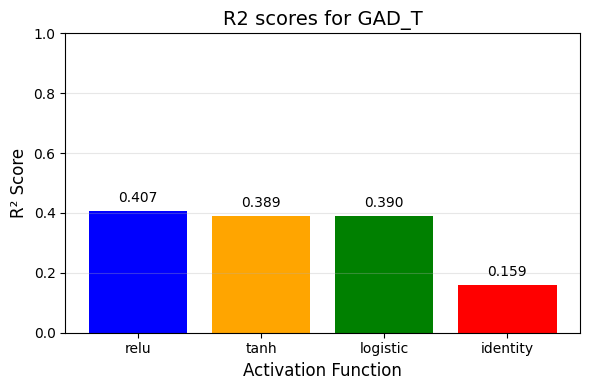

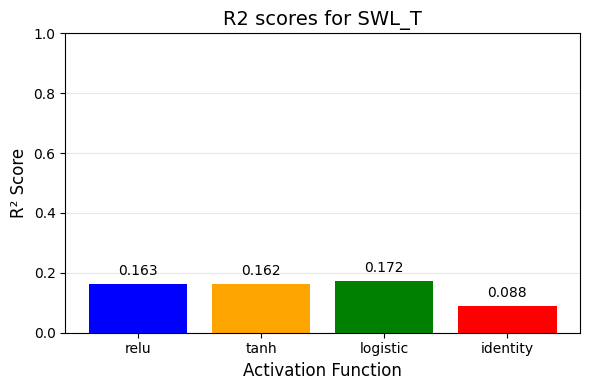

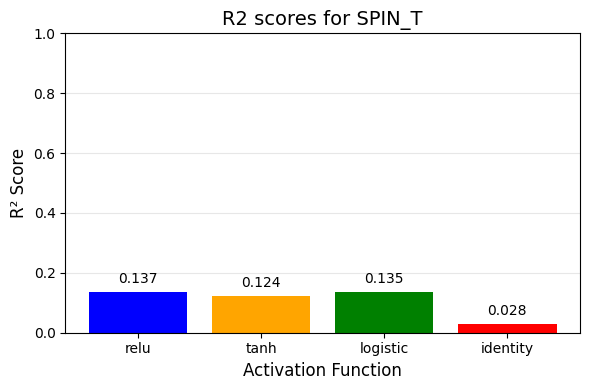

In [54]:
# 4.1 Bar chart comparison of R2 scores

for idx, target in enumerate(target_columns):
    fig, ax = plt.subplots(figsize=(6, 4)) # Create a new figure and a single subplot for each target

    activations = results_df['activation']
    r2_scores = results_df[f'{target}_R2']

    bars = ax.bar(activations, r2_scores, color=['blue', 'orange', 'green', 'red'])
    ax.set_title(f'R2 scores for {target}', fontsize=14)
    ax.set_xlabel('Activation Function', fontsize=12)
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

Here we see that our networks all performed similarly except identity/linear. This likely comes from similar reasons to my conclusions from Q2. The values we are trying to predict are very complex, people's psychology. Even with all the facts a neural network would struggle to accurately predict how a person's brain functions and we are just working with 11 very niche variables.

The result produced by identity is interesting, while every other function produced similar results, identity was significantly worse across the board, being worse than random guessing. This is likely due to not considering the rates or not picking up obvious patterns the other functions did.

Doing the same for MAE values


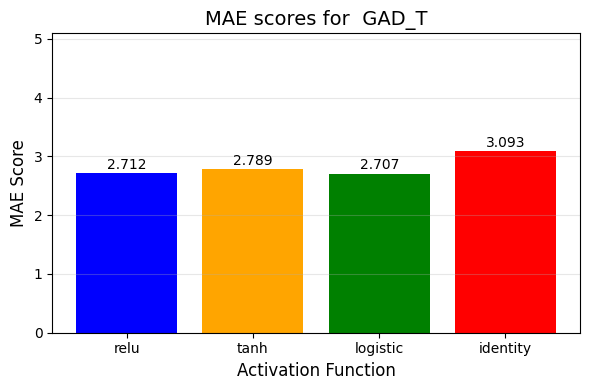

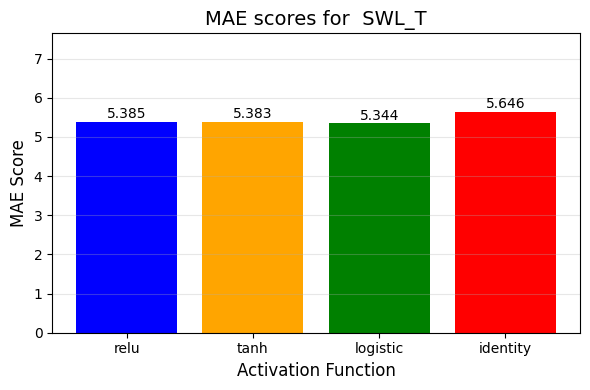

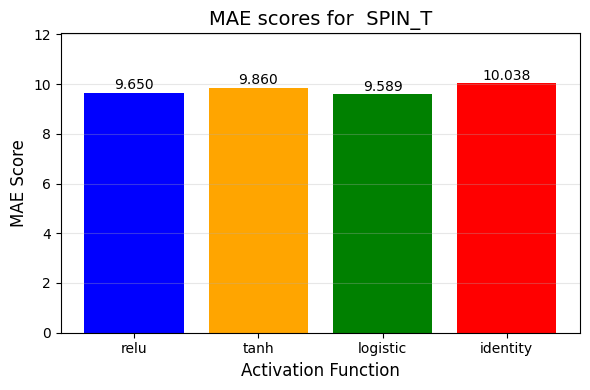

In [52]:
# 4.1 Bar chart comparison of MAE scores

for idx, target in enumerate(target_columns):
    fig, ax = plt.subplots(figsize=(6, 4)) # Create a new figure and a single subplot for each target

    activations = results_df['activation']
    MAE_scores = results_df[f'{target}_MAE']

    bars = ax.bar(activations, MAE_scores, color=['blue', 'orange', 'green', 'red'])
    ax.set_title(f'MAE scores for  {target}', fontsize=14)
    ax.set_xlabel('Activation Function', fontsize=12)
    ax.set_ylabel('MAE Score', fontsize=12)
    y_max = MAE_scores.max()
    ax.set_ylim([0, y_max + 2])
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

The context for our MAE lies within the ranges for each target.

GAD:
- 0-21

SWL:
- 5-35

SPIN:
- 0-68

This highlights the idea that our network is guessing at random, as SWL and SPIN have an error range of around 33% of the total range. (Remember MAE is +- value).

GAD seems to hint at a small amount of pattern recognition, which is reinforced by the R2 values as GAD was significantly higher than the other 2 sets of results. However, this was regardless of activation function if we ignore identities poor performance for all 3.

Now lets look at our loss curve

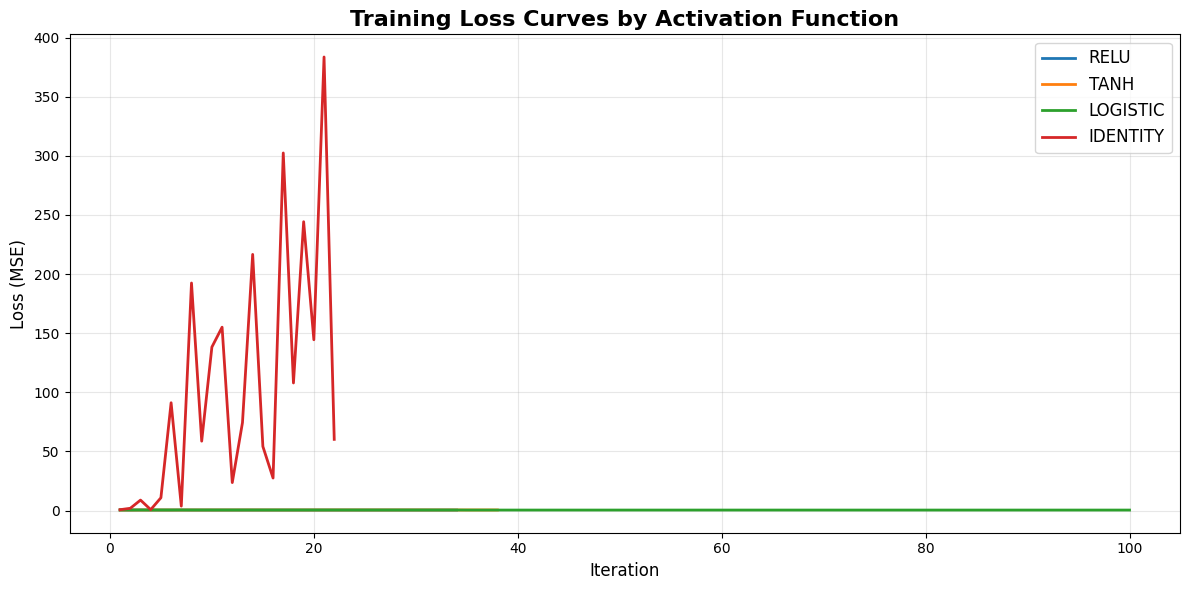

In [56]:
# 4.3 Loss curves comparison
if loss_curves:
    plt.figure(figsize=(12, 6))
    for activation, losses in loss_curves.items():
        plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

    plt.title('Training Loss Curves by Activation Function', fontsize=16, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


The loss curve is a way to visualise how the neural network learned in its training process, however, this figure above is dominated by identity which is shown to randomly fluctuate at large margins. To see the other losses lets look at a plot without identity.

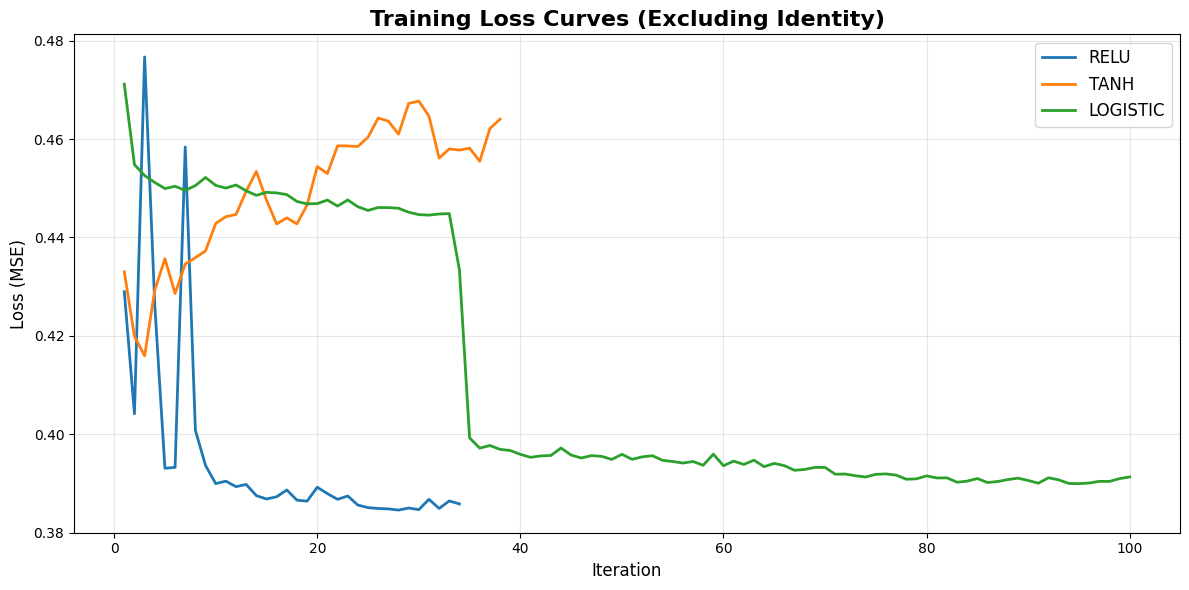

In [58]:
# 1. Filter the loss_curves dictionary to exclude 'identity'
filtered_loss_curves = {key: value for key, value in loss_curves.items() if key != 'identity'}

# 2. Create a new figure and axes for the plot
plt.figure(figsize=(12, 6))

# 3. Iterate through the filtered_loss_curves dictionary and plot each activation function's loss values
for activation, losses in filtered_loss_curves.items():
    plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

# 4. Set the title of the plot and label the axes
plt.title('Training Loss Curves (Excluding Identity)', fontsize=16, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)

# 5. Add a legend
plt.legend(fontsize=12)

# 6. Add a grid to the plot
plt.grid(True, alpha=0.3)

# 7. Use plt.tight_layout() and display the plot
plt.tight_layout()
plt.show()

This plot gives us deeper insight into the other functions.

Relu:
- This curve shows a relatively rapid decrease in loss during the initial iterations, with some fluctuations. It then stabilises and continues to decrease slowly reaching the lowest loss value among the three and maintaining a relatively stable pattern. This suggests that ReLU is converging the best.

Tanh:

- also shows an initial decrease in loss but then starts to increase and fluctuate at a higher loss value compared to ReLU. This indicates that Tanh might be struggling to converge to a lower minimum and possibly overshooting or getting stuck in local minima.

Logistic:
- The Logistic curve initially decreases with some fluctuations, then has a sharp drop around iteration 35, after which it stabilizes at a relatively low loss value, though slightly higher than ReLU. The large drop indicates a point where the model made a significant learning step or found a better path towards minimizing the loss. After this drop, it shows good stability.

